In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
import matplotlib as mpl

In [2]:
# ──────────────────────────────────────────────────────────────
# 1. Load raw data  + helper cols
# ----------------------------------------------------------------
df = pd.read_csv("world_bank.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

df.shape

(17272, 51)

/tmp/ipykernel_1397388/2853893100.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.isna().sum().sum() / g.size * 100)


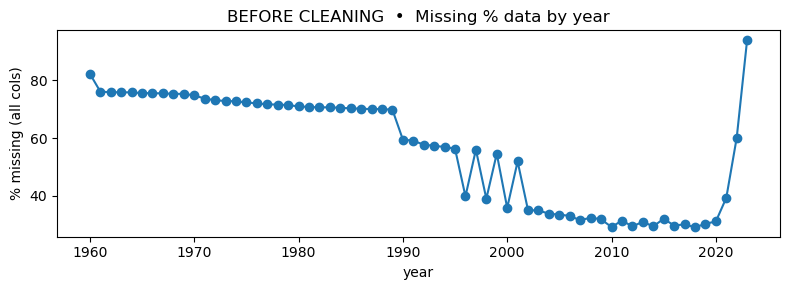

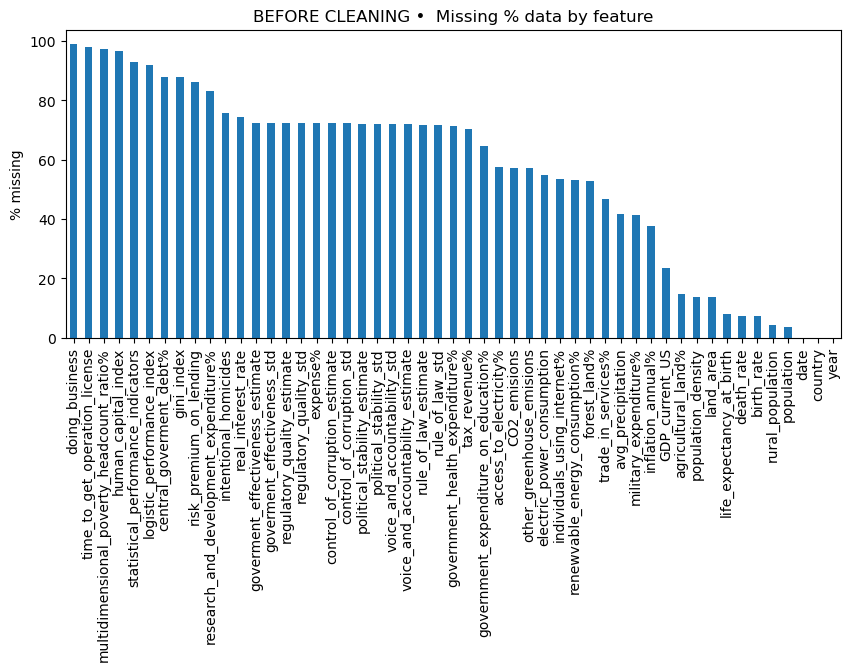

/tmp/ipykernel_1397388/2853893100.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.isna().mean().mean()*100)


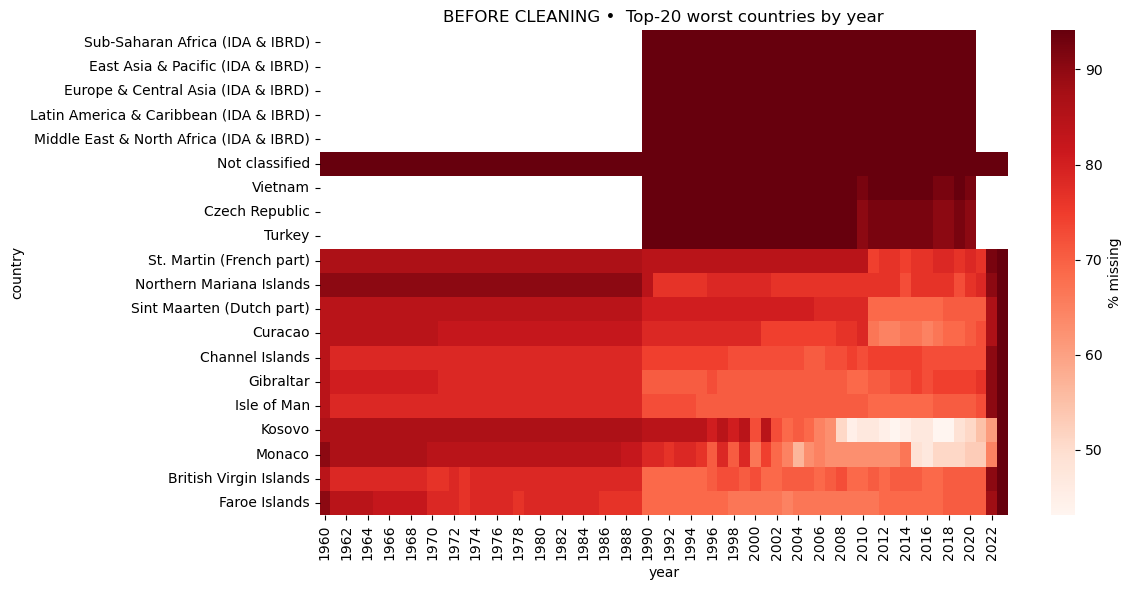

In [3]:
# ──────────────────────────────────────────────────────────────
# 2.  “BEFORE” missingness diagnostics
# ----------------------------------------------------------------
# 2‑A  overall % missing per year
p_missing_year = (
    df.groupby('year')
      .apply(lambda g: g.isna().sum().sum() / g.size * 100)
      .sort_index()
)
plt.figure(figsize=(8,3))
p_missing_year.plot(marker='o')
plt.ylabel('% missing (all cols)')
plt.title('BEFORE CLEANING  •  Missing % data by year')
plt.tight_layout(); plt.show()

# 2‑B  % missing per column 
p_missing_col = df.isna().mean().mul(100).sort_values(ascending=False)
plt.figure(figsize=(10,4))
p_missing_col.plot(kind='bar')
plt.ylabel('% missing')
plt.title('BEFORE CLEANING •  Missing % data by feature')
plt.xticks(rotation=90);  plt.show()

# 2‑C  Heat‑map  •  20 worst countries vs year
worst20 = (df.isna().groupby(df['country']).mean().mean(axis=1)
           .sort_values(ascending=False).head(20).index)
pivot0 = (
    df.groupby(['country','year'])
      .apply(lambda g: g.isna().mean().mean()*100)
      .reset_index(name='missing_pct')
      .pivot(index='country', columns='year', values='missing_pct')
      .reindex(worst20)
)
plt.figure(figsize=(12,6))
sns.heatmap(pivot0, cmap='Reds', annot=False, cbar_kws={'label':'% missing'})
plt.title('BEFORE CLEANING •  Top‑20 worst countries by year')
plt.tight_layout(); plt.show()

In [4]:
# ──────────────────────────────────────────────────────────────
# 3.  Core cleaning steps
# ----------------------------------------------------------------
# Count countries before any filtering
n_before = df['country'].nunique()

# 3-A  Trim to 2002-2020
df = df[df['year'].between(2002, 2020)].copy()

# 3-B  Drop ultra-sparse / discontinued / irrelevant columns
drop_cols = [
    'doing_business', 'time_to_get_operation_license',
    'multidimensional_poverty_headcount_ratio%', 'human_capital_index',
    'risk_premium_on_lending', 'electric_power_consumption',
    'logistic_performance_index', 'statistical_performance_indicators',
    'avg_precipitation',
    'goverment_effectiveness_std', 'regulatory_quality_std',
    'voice_and_accountability_std', 'control_of_corruption_std',
    'rule_of_law_std', 'political_stability_std'
]
df.drop(columns=drop_cols, inplace=True)

# 3-C  Remove “ghost” countries (≥ 90 % missing)
pct_missing = df.isna().groupby(df['country']).mean().mean(axis=1)
ghost_cty = pct_missing[pct_missing >= 0.9].index
df = df[~df['country'].isin(ghost_cty)].copy()
n_after_ghost = df['country'].nunique()

# 3-D  Drop countries with zero Gini observations
has_gini = df.groupby('country')['gini_index'].transform('count') > 0
df = df[has_gini].copy()
n_after_gini = df['country'].nunique()

print(f"Countries before cleaning     : {n_before}")
print(f"After removing ghost countries: {n_after_ghost}")
print(f"After dropping no-Gini ones   : {n_after_gini}")


Countries before cleaning     : 274
After removing ghost countries: 265
After dropping no-Gini ones   : 163


/tmp/ipykernel_1397388/1012359539.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.drop(columns=['country','date','year'])


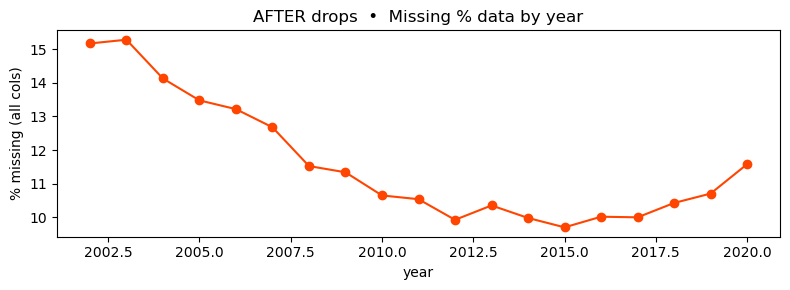

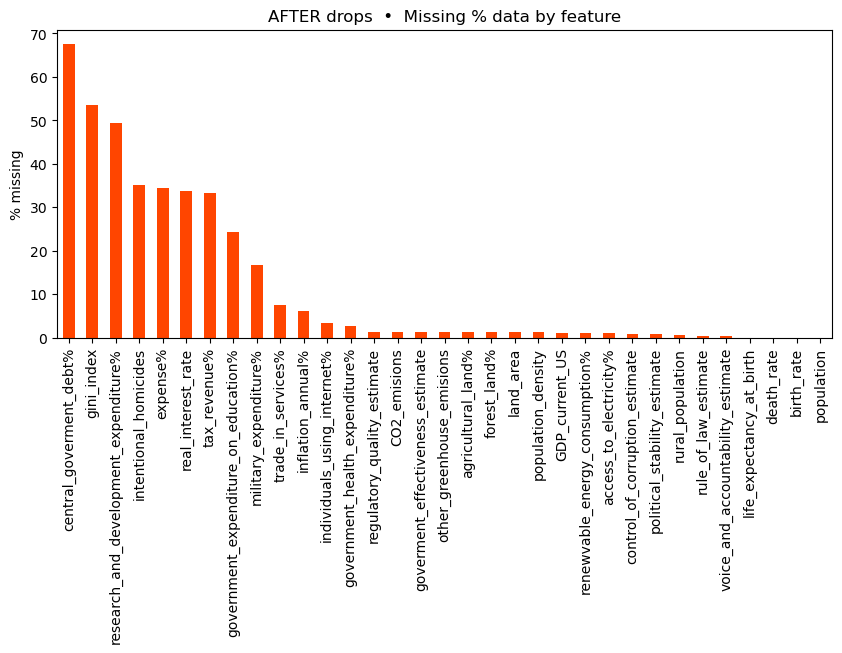

/tmp/ipykernel_1397388/1012359539.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.drop(columns=['country','date','year'])


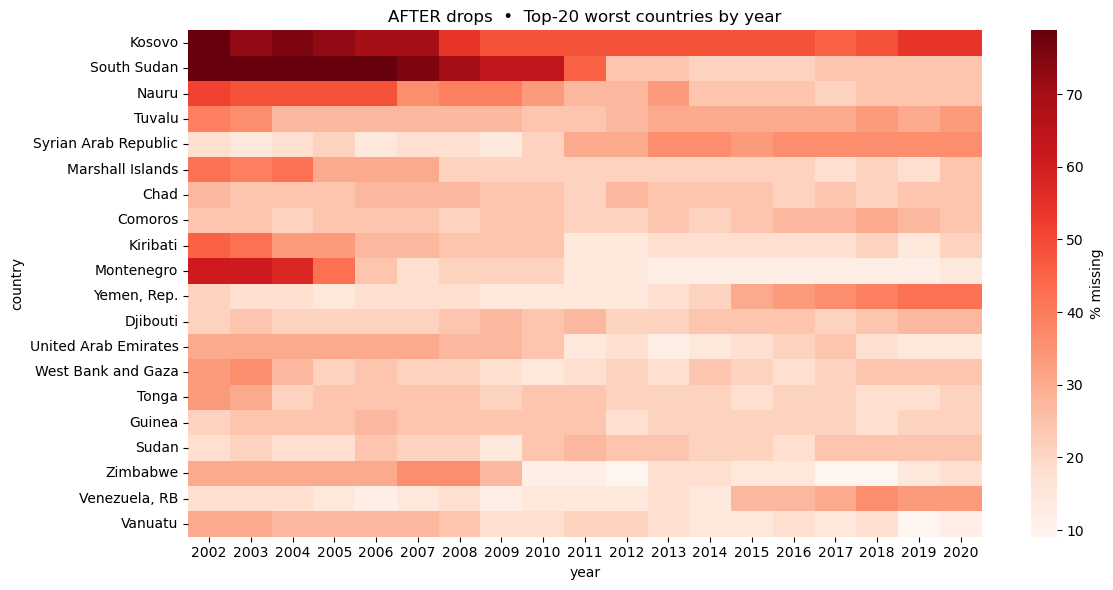

In [5]:
# ──────────────────────────────────────────────────────────────
# Cell 4  ▸  Diagnostics *after* column / country drops, *before* imputation
# -----------------------------------------------------------------
#  At this point:
#     df  – trimmed to 2002‑2020, sparse columns removed,
#            ghost countries & zero‑Gini countries removed
#  We still have real NaNs → plots are meaningful.
# -----------------------------------------------------------------

# 4‑A  % missing by year  -----------------------------------------------
p_missing_year_trim = (
    df.groupby('year')
      .apply(lambda g: g.drop(columns=['country','date','year'])
                        .isna().sum().sum() / g.drop(columns=['country','date','year']).size * 100)
      .sort_index()
)
plt.figure(figsize=(8,3))
p_missing_year_trim.plot(marker='o', color='orangered')
plt.ylabel('% missing (all cols)')
plt.title('AFTER drops  •  Missing % data by year')
plt.tight_layout(); plt.show()

# 4‑B  % missing by feature   -------------------------------------
p_missing_col_trim = (
    df.drop(columns=['country','date','year'])
      .isna().mean()
      .mul(100)
      .sort_values(ascending=False)
)
plt.figure(figsize=(10,4))
p_missing_col_trim.plot(kind='bar', color='orangered')
plt.ylabel('% missing')
plt.title('AFTER drops  •  Missing % data by feature')
plt.xticks(rotation=90); plt.show()

# 4‑C  Heat‑map of worst 20 countries ------------------------------------
worst20_trim = (
    df.drop(columns=['country','date','year'])
      .isna()
      .groupby(df['country']).mean().mean(axis=1)
      .sort_values(ascending=False).head(20).index
)

pivot_trim = (
    df.groupby(['country','year'])
      .apply(lambda g: g.drop(columns=['country','date','year'])
                        .isna().mean().mean()*100)
      .reset_index(name='missing_pct')
      .pivot(index='country', columns='year', values='missing_pct')
      .reindex(worst20_trim)
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_trim, cmap='Reds', cbar_kws={'label':'% missing'})
plt.title('AFTER drops  •  Top‑20 worst countries by year')
plt.tight_layout(); plt.show()


In [6]:
# ──────────────────────────────────────────────────────────────
# Cell 5  ▸  Impute NaNs  (country mean → global mean)
# -----------------------------------------------------------------

print(df.shape)
impute_cols = df.columns.difference(['country', 'date', 'year', 'gini_index'])

df_imp = df.sort_values(['country','date']).copy()

# 1) per‑country mean
df_imp[impute_cols] = (
    df_imp.groupby('country')[impute_cols]
          .transform(lambda g: g.fillna(g.mean()))
)

# 2) global mean fallback
df_imp[impute_cols] = df_imp[impute_cols].fillna(df_imp[impute_cols].mean())

df_imp


(3097, 36)


,country,date,agricultural_land%,forest_land%,land_area,trade_in_services%,control_of_corruption_estimate,access_to_electricity%,renewvable_energy_consumption%,CO2_emisions,...,government_health_expenditure%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,intentional_homicides,year
234,Albania,2002-01-01,41.605839,28.169854,27400.0,26.959328,-0.845341,99.404579,35.82,3761.9,...,2.588679,31.7,15.209,5.953,75.890,3051010.0,1723790.0,-0.008150,6.915206,2002
235,Albania,2003-01-01,40.912409,28.216460,27400.0,27.598163,-0.853787,99.385628,33.67,4137.4,...,2.670353,NaN,14.668,6.057,76.142,3039616.0,1684768.0,0.070308,5.366973,2003
236,Albania,2004-01-01,40.948905,28.263066,27400.0,30.002777,-0.723732,99.372139,35.84,4322.3,...,2.820827,NaN,13.978,6.181,76.376,3026939.0,1645111.0,0.007237,4.277380,2004
237,Albania,2005-01-01,39.306569,28.309672,27400.0,32.905109,-0.813264,99.371124,36.77,4095.9,...,2.665318,30.6,13.235,6.306,76.621,3011487.0,1604189.0,0.003672,5.078094,2005
238,Albania,2006-01-01,40.875912,28.356277,27400.0,36.187926,-0.790545,99.389366,31.62,4081.8,...,2.559311,NaN,12.539,6.477,76.816,2992547.0,1561661.0,0.075890,3.163096,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17264,Zimbabwe,2016-01-01,41.876696,45.570273,386850.0,8.080966,-1.288441,42.465588,82.07,10450.2,...,1.581913,NaN,33.171,8.441,60.306,14452704.0,9785059.0,-1.178460,8.362394,2016
17265,Zimbabwe,2017-01-01,41.876696,45.451183,386850.0,9.140222,-1.298485,43.979065,82.63,9781.0,...,1.598481,44.3,32.516,8.266,60.709,14751101.0,9995789.0,-1.195905,8.362394,2017
17266,Zimbabwe,2018-01-01,41.876696,45.332093,386850.0,4.469742,-1.246001,45.400288,80.43,11069.9,...,1.594279,NaN,32.074,7.972,61.414,15052184.0,10204026.0,-1.136798,4.876369,2018
17267,Zimbabwe,2019-01-01,41.876696,45.213002,386850.0,6.927164,-1.271190,46.682095,81.52,10185.3,...,0.522077,50.3,31.518,8.043,61.292,15354608.0,10408889.0,-1.163669,5.145035,2019


In [7]:
# ──────────────────────────────────────────────────────────────
# Cell 6  ▸  Engineering  •  rolling stats  + 4 lags  +  gini_next
# -----------------------------------------------------------------
df_feat = df_imp.sort_values(['country','date']).copy()

# 6‑A  rolling 5‑year mean & std
rolled = df_feat.groupby('country')[impute_cols].rolling(5, min_periods=5)
roll_mean = rolled.mean().reset_index(level=0, drop=True).add_suffix('_rollmean')
roll_std  = rolled.std() .reset_index(level=0, drop=True).add_suffix('_rollstd')
df_feat = pd.concat([df_feat, roll_mean, roll_std], axis=1)


# 6‑B  add 4 year‑lags for raw cols
lag_frames = []
for lag in range(1, 5):
    lag_df = (df_feat.groupby('country')[impute_cols]
                      .shift(lag)
                      .add_suffix(f'_lag{lag}'))
    lag_frames.append(lag_df)
df_feat = pd.concat([df_feat] + lag_frames, axis=1)

# 6‑C  next‑year Gini target
df_feat['gini_next'] = df_feat.groupby('country')['gini_index'].shift(-1)

df_feat = df_feat.drop(columns = 'gini_index')

df_feat


,country,date,agricultural_land%,forest_land%,land_area,trade_in_services%,control_of_corruption_estimate,access_to_electricity%,renewvable_energy_consumption%,CO2_emisions,...,real_interest_rate_lag4,regulatory_quality_estimate_lag4,renewvable_energy_consumption%_lag4,research_and_development_expenditure%_lag4,rule_of_law_estimate_lag4,rural_population_lag4,tax_revenue%_lag4,trade_in_services%_lag4,voice_and_accountability_estimate_lag4,gini_next
234,Albania,2002-01-01,41.605839,28.169854,27400.0,26.959328,-0.845341,99.404579,35.82,3761.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,Albania,2003-01-01,40.912409,28.216460,27400.0,27.598163,-0.853787,99.385628,33.67,4137.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,Albania,2004-01-01,40.948905,28.263066,27400.0,30.002777,-0.723732,99.372139,35.84,4322.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.6
237,Albania,2005-01-01,39.306569,28.309672,27400.0,32.905109,-0.813264,99.371124,36.77,4095.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,Albania,2006-01-01,40.875912,28.356277,27400.0,36.187926,-0.790545,99.389366,31.62,4081.8,...,11.246478,-0.311401,35.82,0.120845,-0.762321,1723790.0,16.484242,26.959328,-0.008150,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17264,Zimbabwe,2016-01-01,41.876696,45.570273,386850.0,8.080966,-1.288441,42.465588,82.07,10450.2,...,6.428554,-1.871891,77.64,0.763671,-1.630184,8909792.0,17.835489,12.366966,-1.471968,44.3
17265,Zimbabwe,2017-01-01,41.876696,45.451183,386850.0,9.140222,-1.298485,43.979065,82.63,9781.0,...,1.525435,-1.854899,79.04,0.763671,-1.587261,9129035.0,14.827050,11.780033,-1.386220,NaN
17266,Zimbabwe,2018-01-01,41.876696,45.332093,386850.0,4.469742,-1.246001,45.400288,80.43,11069.9,...,8.787605,-1.892658,80.45,0.763671,-1.441469,9352079.0,14.827050,11.882129,-1.256889,50.3
17267,Zimbabwe,2019-01-01,41.876696,45.213002,386850.0,6.927164,-1.271190,46.682095,81.52,10185.3,...,8.144427,-1.656233,81.00,0.763671,-1.338473,9570861.0,17.673363,9.569889,-1.166087,NaN


In [8]:
# ──────────────────────────────────────────────────────────────
# Cell 7  ▸  Split ≥ 2007 data  •  scale (no imputation)  •  sanity‑check
# -----------------------------------------------------------------
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing  import StandardScaler
import joblib

# 7‑A  keep rows we can use- drop pre 2007 rows (its been converted to columns essentially) & drop no gini-next rows-------------------------------------------------
df_feat = df_feat[df_feat['year'] >= 2007].copy()
df_feat = df_feat[df_feat['gini_next'].notna()].reset_index(drop=True)


# 7‑B  split X / y by country ---------------------------------------------
all_X = df_feat.drop(columns=['gini_next'])
all_y = df_feat['gini_next']
groups = df_feat['country']

gss = GroupShuffleSplit(test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(all_X, all_y, groups=groups))

all_X_train, all_X_test = all_X.iloc[train_idx].copy(), all_X.iloc[test_idx].copy()
y_train, y_test         = all_y.iloc[train_idx],           all_y.iloc[test_idx]

# ➊  save the group (country) labels to use for group k-fold cross validation
groups_train = groups.iloc[train_idx].reset_index(drop=True)
groups_train.to_csv('groups_train.csv', index=False)
groups_test = groups.iloc[test_idx].reset_index(drop=True)
groups_test.to_csv('groups_test.csv', index=False)

# 7‑C  standardise numeric columns -------------------------
num_cols = all_X_train.select_dtypes(include='number').columns

scaler = StandardScaler().set_output(transform='pandas')
all_X_train[num_cols] = scaler.fit_transform(all_X_train[num_cols])
all_X_test[num_cols]  = scaler.transform(all_X_test[num_cols])

joblib.dump(scaler, 'scaler.pkl')

# 7‑D  sanity‑check: there should be *zero* NaNs now -----------------------
assert all_X_train.isna().sum().sum() == 0
assert all_X_test.isna().sum().sum()  == 0

print(f"Scaled feature matrix  →  train {all_X_train.shape},  test {all_X_test.shape}")


Scaled feature matrix  →  train (813, 227),  test (216, 227)


In [9]:
# ──────────────────────────────────────────────────────────────
# Cell 8  ▸  Build & save three datasets directly from the
#           already‑scaled all_X_train / all_X_test
# -----------------------------------------------------------------

# Helper columns to remove from every dataset
helper_cols = ['country', 'date', 'year', 'gini_index']

# Identify column groups from the TRAIN dataframe
roll_cols = [c for c in all_X_train.columns if c.endswith(('_rollmean', '_rollstd'))]
lag_cols  = [c for c in all_X_train.columns if c.endswith(('_lag1', '_lag2', '_lag3', '_lag4'))]

# Base (year‑t raw) columns  = everything minus helpers, roll, lag
base_cols = [
    c for c in all_X_train.columns
    if c not in helper_cols + roll_cols + lag_cols
]

def save_csv_pair(X_tr, X_te, tag):
    """Drop helper cols from the provided frames and save CSVs."""
    X_tr = X_tr.drop(columns=helper_cols, errors='ignore').copy()
    X_te = X_te.drop(columns=helper_cols, errors='ignore').copy()
    X_tr.to_csv(f'X{tag}_train.csv', index=False)
    X_te.to_csv(f'X{tag}_test.csv',  index=False)

# Dataset 1  – year‑t raw features only
save_csv_pair(all_X_train[base_cols], all_X_test[base_cols], tag='1')

# Dataset 2  – year‑t + rolling mean / std
cols_ds2 = base_cols + roll_cols
save_csv_pair(all_X_train[cols_ds2], all_X_test[cols_ds2], tag='2')

# Dataset 3  – year‑t + 4 lags
cols_ds3 = base_cols + lag_cols
save_csv_pair(all_X_train[cols_ds3], all_X_test[cols_ds3], tag='3')

# Save the target vectors once
y_train.to_frame('gini_next').to_csv('y_train.csv', index=False)
y_test .to_frame('gini_next').to_csv('y_test.csv',  index=False)

print("✓  X1/X2/X3 (train & test) and y saved using the scaled data.")


✓  X1/X2/X3 (train & test) and y saved using the scaled data.


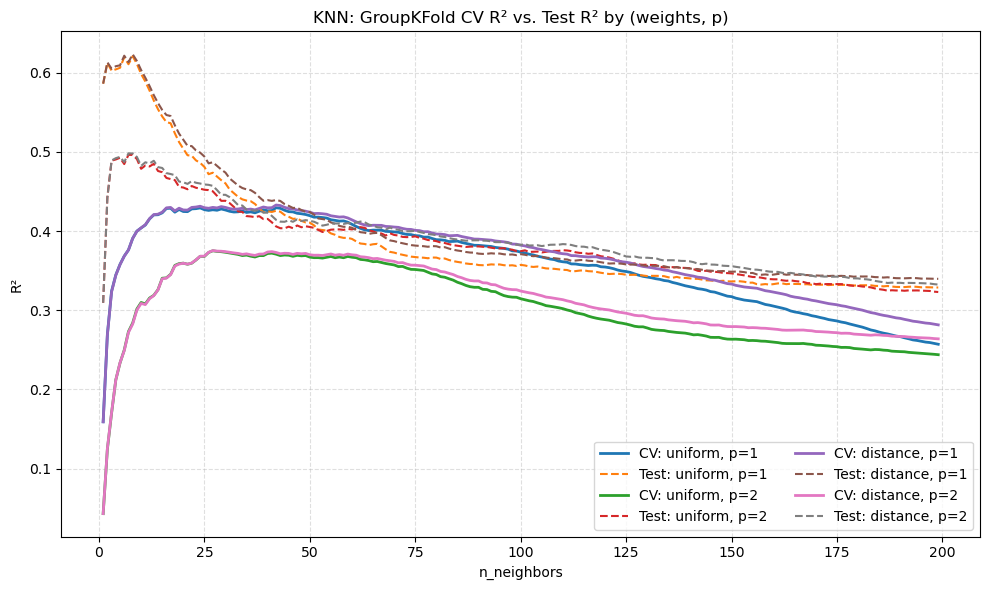

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics         import r2_score

# 1) Load data
X_train      = pd.read_csv("X2_train.csv")
y_train      = pd.read_csv("y_train.csv")['gini_next']
groups_train = pd.read_csv("groups_train.csv")['country']
X_test       = pd.read_csv("X2_test.csv")
y_test       = pd.read_csv("y_test.csv")['gini_next']

# 2) Define grid and run group-aware GridSearchCV
param_grid = {
    'n_neighbors': np.arange(1, 200, 1),
    'weights'    : ['uniform', 'distance'],
    'p'          : [1, 2]
}
gkf = GroupKFold(n_splits=5)
knn_grid = GridSearchCV(
    KNeighborsRegressor(), param_grid,
    cv=gkf.split(X_train, y_train, groups=groups_train),
    scoring='r2', n_jobs=-1, return_train_score=True
)
knn_grid.fit(X_train, y_train)

# 3) Assemble CV results DataFrame
results = pd.DataFrame(knn_grid.cv_results_)
results['param_n_neighbors'] = results['param_n_neighbors'].astype(int)
results['param_p']           = results['param_p'].astype(int)

# 4) Compute test R² for every combination
test_scores = []
for idx, row in results.iterrows():
    knn = KNeighborsRegressor(
        n_neighbors = row['param_n_neighbors'],
        weights     = row['param_weights'],
        p           = row['param_p']
    )
    knn.fit(X_train, y_train)
    test_scores.append(r2_score(y_test, knn.predict(X_test)))
results['test_r2'] = test_scores

# 5) Plot CV vs. test R² for each (weights, p) combination
plt.figure(figsize=(10,6))
for w in param_grid['weights']:
    for p in param_grid['p']:
        subset = results[
            (results['param_weights'] == w) &
            (results['param_p']       == p)
        ]
        plt.plot(
            subset['param_n_neighbors'],
            subset['mean_test_score'],
            label=f"CV: {w}, p={p}",
            lw=2
        )
        plt.plot(
            subset['param_n_neighbors'],
            subset['test_r2'],
            linestyle='--',
            label=f"Test: {w}, p={p}"
        )

plt.xlabel('n_neighbors')
plt.ylabel('R²')
plt.title('KNN: GroupKFold CV R² vs. Test R² by (weights, p)')
plt.legend(loc='lower right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [11]:
all_X_train

,country,date,agricultural_land%,forest_land%,land_area,trade_in_services%,control_of_corruption_estimate,access_to_electricity%,renewvable_energy_consumption%,CO2_emisions,...,population_density_lag4,real_interest_rate_lag4,regulatory_quality_estimate_lag4,renewvable_energy_consumption%_lag4,research_and_development_expenditure%_lag4,rule_of_law_estimate_lag4,rural_population_lag4,tax_revenue%_lag4,trade_in_services%_lag4,voice_and_accountability_estimate_lag4
0,Albania,2007-01-01,-0.085836,-0.152721,-0.399383,0.246248,-0.858644,0.383715,0.255218,-0.282704,...,-0.092005,0.484585,-0.901169,0.339480,-0.937331,-0.894981,-0.238838,-0.002647,0.057529,-0.220551
1,Albania,2011-01-01,0.068972,-0.142467,-0.399383,0.285449,-0.853645,0.397989,0.425933,-0.282038,...,-0.104831,0.593406,-0.327628,0.267937,-0.976154,-0.841427,-0.240249,0.078050,0.356602,-0.175593
2,Albania,2013-01-01,0.043107,-0.136912,-0.399383,0.134583,-0.901404,0.406433,0.661555,-0.282297,...,-0.112664,0.704647,-0.101502,0.485994,-0.937331,-0.677986,-0.240969,0.078050,0.441205,-0.145619
3,Albania,2014-01-01,0.018546,-0.134134,-0.399383,0.163169,-0.741290,0.409369,0.546856,-0.281999,...,-0.115336,0.380244,-0.110425,0.481710,-0.937331,-0.571803,-0.241296,0.078050,0.378675,-0.164191
4,Albania,2015-01-01,0.018565,-0.131356,-0.399383,0.160795,-0.700725,0.410845,0.543744,-0.282295,...,-0.116778,0.686701,-0.055023,0.432444,-0.937331,-0.627692,-0.241594,0.119843,0.401904,-0.228947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,Zambia,2009-01-01,-0.557173,1.689781,-0.142956,-0.517271,-0.627973,-3.199006,2.775041,-0.284048,...,-0.573640,0.689997,-1.177031,2.696120,-1.049238,-0.700637,-0.191479,-0.358807,-0.416209,-0.747673
1025,Zambia,2014-01-01,-0.546596,1.633068,-0.142956,-0.482470,-0.509632,-3.134641,2.556757,-0.282379,...,-0.558511,0.083271,-0.939003,2.692265,-0.999159,-0.679998,-0.182465,-0.649495,-0.544365,-0.550439
1026,Zimbabwe,2010-01-01,-0.032179,0.803381,-0.270648,-0.367797,-1.505986,-2.594249,2.500741,-0.278717,...,-0.491242,-4.022456,-2.479607,2.267290,-0.187330,-1.907213,-0.184297,-0.354019,-0.460389,-1.915194
1027,Zimbabwe,2016-01-01,-0.032179,0.765177,-0.270648,-0.510880,-1.423560,-2.418186,2.481180,-0.278010,...,-0.479039,0.133714,-2.411264,2.223164,-0.187330,-1.788426,-0.177861,0.092178,-0.391885,-1.844362
